In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import random
random.seed(8675309)
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import ImageFile 
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint 
from extract_bottleneck_features import *

Using TensorFlow backend.


In [23]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [34]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


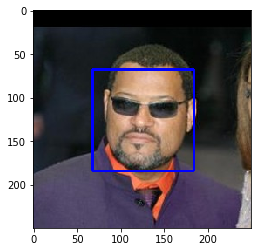

In [35]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [36]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [37]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
accuracy_dog = 100-np.array(list(map(face_detector, dog_files_short))).sum()
accuracy_human = np.array(list(map(face_detector, human_files_short))).sum()

print('Accuracy on Dogs Files: {}% Accuracy on Human Files: {}%'.format(accuracy_dog, accuracy_human))

Accuracy on Dogs Files: 88% Accuracy on Human Files: 99%


In [38]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_mod = ResNet50(weights='imagenet')

In [39]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [40]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_mod.predict(img))

In [41]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [42]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
accuracy_dog = (np.array(list(map(dog_detector, dog_files_short)))).mean()
accuracy_human = (1-(np.array(list(map(dog_detector,human_files_short))))).mean()
print('Accuracy on Dog Files: {:.0f}%\nAccuracy on Human Files: {:.0f}%'.format(accuracy_dog*100,accuracy_human*100))

Accuracy on Dog Files: 100%
Accuracy on Human Files: 99%


In [3]:
bottleneck_features = np.load('DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [4]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [7]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

In [9]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)].split('.')[-1]

In [10]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

In [11]:
ResNet50_model = Sequential()
ResNet50_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet50_model.add(Dense(133, activation='softmax'))

ResNet50_model.summary()
### Define the model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [12]:
ResNet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
### Compile the model

In [14]:
ResNet50_model.load_weights('saved_models/weights.best.ResNet50.hdf5')
### Load the model weights with the best validation loss.VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

This image looks like a American_water_spaniel.


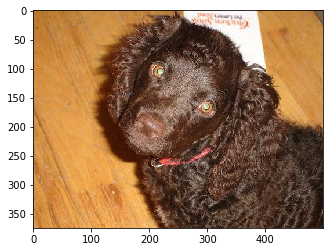

In [25]:
### A function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
img_path = 'images/American_water_spaniel_00648.jpg'
#img_path = dog_files_short[2]
def classify_dog_breed(img_path):
    img = path_to_tensor(img_path)
    bottleneck_feature = extract_Resnet50(img)
#     print(bottleneck_feature.shape)
    bottleneck_feature = np.expand_dims(bottleneck_feature, axis=0)
    bottleneck_feature = np.expand_dims(bottleneck_feature, axis=0)
#     print(bottleneck_feature.shape)
    predictions = ResNet50_model.predict(bottleneck_feature)
    prediction = np.argmax(predictions)
    dog_names[prediction].split('.')[-1]
    print('This image looks like a {}.'.format(dog_names[prediction].split('.')[-1]))
    return dog_names[prediction].split('.')[-1]
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
prediction = classify_dog_breed(img_path)

Dog Detected
This image looks like a Curly-coated_retriever.




'Curly-coated_retriever'

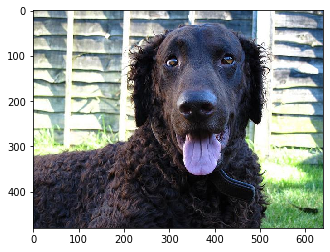

In [43]:
def return_breed(img_path):
    if face_detector(img_path):
        print('Human Detected')
        print('\n')
        return 'Human'
    elif dog_detector(img_path):
        print('Dog Detected')
        breed = classify_dog_breed(img_path)
        print('\n')
        return breed
    else:
        print('Neither Human nor Dog detected')
        print('\n')
        return 'Neither human nor dog'

img_path = 'images/Curly-coated_retriever_03896.jpg'   
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
return_breed(img_path)